## Cold-Start Mitigation Strategies

When a new user arrives without any history, we can employ several fallback approaches:

1. **Popularity-based (Global Top-N)**  
   Recommend the highest-rated movies across the entire user base.  
   - **Pros:** Requires no per-user data; simple and fast.  
   - **Cons:** Not personalized; tends to surface the same blockbuster titles.

2. **Content-based Bootstrapping**  
   Ask the user to rate a small seed set of movies (e.g. 1–5). Build a genre-based profile from those few ratings using TF-IDF over genre tags, then recommend items most similar to that profile.  
   - **Pros:** Quick personalization from minimal input.  
   - **Cons:** Quality depends heavily on the seed movies chosen.

3. **Demographic-based Recommendations**  
   Use available demographic information (e.g. age bracket, occupation, gender) to recommend movies popular among similar users. Compute per-movie average ratings within that demographic group and recommend the top items.  
   - **Pros:** Leverages peer preferences; no initial ratings required.  
   - **Cons:** Requires collecting demographic data and may be coarse.

Below we simulate “new users” with 0–5 initial ratings and compare these three strategies by computing **nDCG@10** against their held-out test ratings.


In [1]:
# Cell: Setup & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load full ratings and split
df = pd.read_csv('storage/u.data', sep='\t', names=['user','item','rating','timestamp'])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['user'])

# Precompute global popularity
global_avg = train_df.groupby('item')['rating'].mean().sort_values(ascending=False)

# Load metadata for genres and demographics
items_meta = pd.read_csv('storage/u.item', sep='|', encoding='latin-1',
    names=['item','title','release_date','video_release_date','IMDb_URL',
           'unknown','Action','Adventure','Animation','Children','Comedy',
           'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
           'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'])
# Demographics
users_demo = pd.read_csv('storage/u.user', sep='|', names=['user','age','gender','occupation','zip'])

# Compute demographic-based averages per occupation
occ_avg = (train_df.merge(users_demo[['user','occupation']], on='user')
                .groupby(['occupation','item'])['rating']
                .mean()
                .reset_index())


In [2]:
# Cell: Content-based Profiles
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Build item profiles via TF-IDF on genres
genre_cols = items_meta.columns[6:]
items_meta['features'] = items_meta[genre_cols].apply(lambda r: ' '.join(genre_cols[r==1]), axis=1)
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(items_meta['features'])
item_profiles = pd.DataFrame(tfidf_mat.toarray(), index=items_meta['item'])


In [3]:
# Cell: Helper Functions (nDCG, recommenders)
def ndcg_for_user(user, rec_items, actual_df, k=10):
    actual = dict(zip(
        actual_df[actual_df['user']==user]['item'],
        actual_df[actual_df['user']==user]['rating']
    ))
    dcg = sum((2**actual.get(item,0)-1) / np.log2(idx+2)
              for idx,item in enumerate(rec_items))
    ideal = sorted(actual.values(), reverse=True)[:k]
    idcg = sum((2**r-1)/np.log2(i+2) for i,r in enumerate(ideal))
    return dcg/idcg if idcg>0 else 0

# Precomputed globals from train_df
global_avg = train_df.groupby('item')['rating'] \
                     .mean() \
                     .sort_values(ascending=False)

# Recompute demographic‐by‐occupation averages on train only
occ_avg = (
    train_df
    .merge(users_demo[['user','occupation']], on='user')
    .groupby(['occupation','item'])['rating']
    .mean()
    .reset_index()
)

# ─── Popularity by count ───
item_counts = train_df['item'].value_counts()

def rec_popularity(user, top_n=10):
    seen = set(train_df[train_df['user']==user]['item'])
    # Recommend the items with the highest count (most rated) that the user hasn't seen
    return [item for item in item_counts.index if item not in seen][:top_n]


def rec_content(user, k, top_n=10):
    # sample k ratings for this user
    known = train_df[train_df['user']==user]
    if len(known)==0 or k==0:
        return rec_popularity(user, top_n)
    observed = known.sample(n=min(k,len(known)), random_state=42)
    # build user profile
    prof = sum(item_profiles.loc[it].values * r
               for it,r in zip(observed['item'], observed['rating'])
               if it in item_profiles.index)
    prof_norm = prof/np.linalg.norm(prof) if np.linalg.norm(prof)>0 else prof
    # score all items
    scores = item_profiles.dot(prof_norm)
    ranked = scores.sort_values(ascending=False).index
    return [i for i in ranked if i not in observed['item']][:top_n]

# ─── Demographic popularity by count ───
occ_counts = (
    train_df
    .merge(users_demo[['user','occupation']], on='user')
    .groupby(['occupation','item'])
    .size()
    .reset_index(name='count')
)

def rec_demographic(user, top_n=10):
    seen = set(train_df[train_df['user']==user]['item'])
    occ = users_demo.loc[users_demo['user']==user, 'occupation'].iat[0]
    # filter to this occupation, sort by count descending
    candidates = occ_counts[occ_counts['occupation']==occ] \
                    .sort_values('count', ascending=False)
    recs = [item for item in candidates['item'] if item not in seen]
    return recs[:top_n]

# Debug: what are the top‐10 “popular” items?
print(global_avg.head(10))


item
1189    5.0
1653    5.0
1293    5.0
1467    5.0
1122    5.0
1536    5.0
1500    5.0
1617    5.0
1358    5.0
1599    5.0
Name: rating, dtype: float64


In [4]:
# Cell: Simulation & Performance Measurement
ks = [0,1,2,3,5]
strategies = {'Popularity': rec_popularity,
              'Content-based': lambda u, k, n=10: rec_content(u,k,n),
              'Demographic': rec_demographic}

results = {name: [] for name in strategies}

# Sample a subset of users with enough data
users = train_df['user'].unique()
np.random.seed(42)
sample_users = np.random.choice(users, size=100, replace=False)

for k in ks:
    for name, func in strategies.items():
        scores = []
        for u in sample_users:
            recs = func(u, k) if name=='Content-based' else func(u)
            nd = ndcg_for_user(u, recs, test_df, k=10)
            scores.append(nd)
        results[name].append(np.mean(scores))

# Assemble DataFrame
cold_df = pd.DataFrame(results, index=ks)
cold_df.index.name = 'initial_ratings'
cold_df


,Popularity,Content-based,Demographic
initial_ratings,,,
0,0.145265,0.145265,0.152132
1,0.145265,0.012782,0.152132
2,0.145265,0.014245,0.152132
3,0.145265,0.013730,0.152132
5,0.145265,0.014718,0.152132


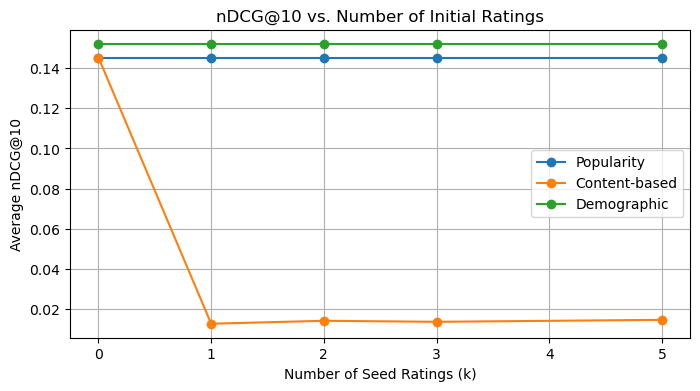

In [5]:
# Cell: Visualization
plt.figure(figsize=(8,4))
for name in strategies:
    plt.plot(cold_df.index, cold_df[name], marker='o', label=name)
plt.title('nDCG@10 vs. Number of Initial Ratings')
plt.xlabel('Number of Seed Ratings (k)')
plt.ylabel('Average nDCG@10')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# ─── 1. Curated‑seed Content‑Based Recommender ───
def rec_content_curated(user, k, top_n=10):
    """
    Use the user's _top‑rated_ k items instead of a random sample
    to build their TF‑IDF profile.  Falls back to popularity if k=0.
    """
    known = train_df[train_df['user'] == user]
    if known.empty or k == 0:
        return rec_popularity(user, top_n)
    # pick the highest‑rated k for this user
    observed = known.sort_values('rating', ascending=False).head(k)
    # aggregate & normalize
    prof = sum(item_profiles.loc[it].values * r
               for it, r in zip(observed['item'], observed['rating'])
               if it in item_profiles.index)
    norm = np.linalg.norm(prof)
    prof_norm = prof / norm if norm>0 else prof
    # score & filter out seen
    scores = item_profiles.dot(prof_norm)
    ranked = scores.sort_values(ascending=False).index
    return [i for i in ranked if i not in set(observed['item'])][:top_n]


# ─── 2. Generic nDCG Simulator ───
def simulate_ndcg(func, ks, user_list):
    """
    For each k in ks, call recs = func(user, k) and compute
    avg nDCG@10 over all users in user_list.
    """
    return np.array([
        np.mean([ndcg_for_user(u, func(u, k_val), test_df, k=10)
                 for u in user_list])
        for k_val in ks
    ])


# ─── 3. Novelty Calculator ───
def compute_novelty(func, ks, user_list, top_pop_n=20):
    """
    Novelty = fraction of recommendations outside the top_pop_n
    most‑popular items.
    """
    popular_set = set(item_counts.index[:top_pop_n])
    return np.array([
        np.mean([
            np.mean([1 if i not in popular_set else 0 for i in func(u, k_val)])
            for u in user_list
        ])
        for k_val in ks
    ])


# ─── 4. Hybrid Weight Scheduler ───
def compute_hybrid_weights(ks):
    """
    Example schedule:
      α(k)=pop weight,  β(k)=demo weight,  γ(k)=content weight  
    α(0)=1,β(0)=0.5,γ(0)=0  
    then α↓0.15 per seed, β↓0.05 per seed, γ=1–α–β
    """
    alpha = np.where(ks==0, 1.0, np.where(ks<=5, 1 - 0.15*ks, 0))
    beta  = np.where(ks==0, 0.5, np.where(ks<=5, 0.5 - 0.05*ks, 0))
    gamma = 1 - alpha - beta
    return alpha, beta, gamma


# ─── 5. Pulling It All Together ───
# Extend k to test up to 10 and 20 seed ratings
ks = np.array([0, 1, 2, 3, 5, 10, 20])

# recompute all the curves over the new ks
pop_ndcg        = simulate_ndcg(lambda u, k: rec_popularity(u),     ks, sample_users)
demo_ndcg       = simulate_ndcg(lambda u, k: rec_demographic(u),     ks, sample_users)
cb_random_ndcg  = simulate_ndcg(lambda u, k: rec_content(u, k),      ks, sample_users)
cb_curated_ndcg = simulate_ndcg(rec_content_curated,                ks, sample_users)

nov_pop  = compute_novelty(lambda u, k: rec_popularity(u),           ks, sample_users)
nov_demo = compute_novelty(lambda u, k: rec_demographic(u),         ks, sample_users)
nov_cb   = compute_novelty(rec_content_curated,                      ks, sample_users)

alpha, beta, gamma = compute_hybrid_weights(ks)



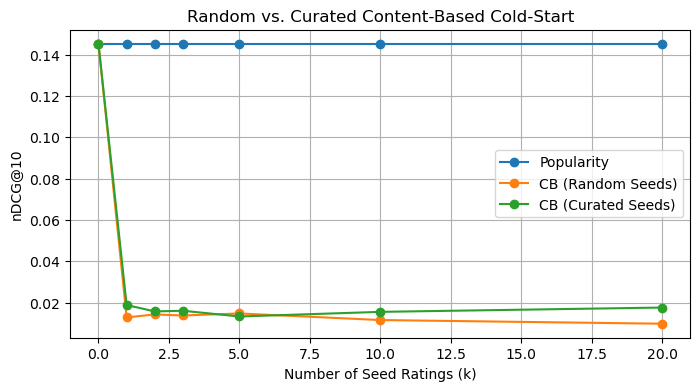

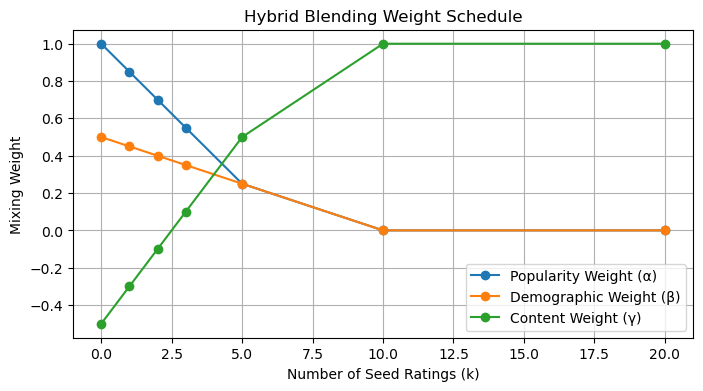

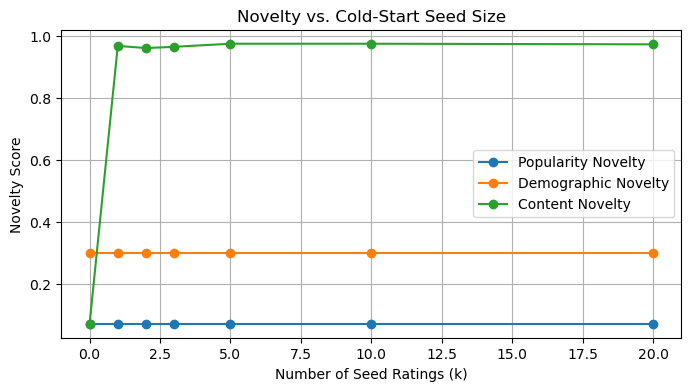

In [7]:
# ─── DataFrame for “Random vs Curated CB” ───
df = pd.DataFrame({
    'k':                   ks,
    'Popularity':          pop_ndcg,
    'Demographic':         demo_ndcg,
    'CB (Random Seeds)':   cb_random_ndcg,
    'CB (Curated Seeds)':  cb_curated_ndcg
})

plt.figure(figsize=(8,4))
for col in ['Popularity','CB (Random Seeds)','CB (Curated Seeds)']:
    plt.plot(df['k'], df[col], marker='o', label=col)
plt.title('Random vs. Curated Content-Based Cold-Start')
plt.xlabel('Number of Seed Ratings (k)')
plt.ylabel('nDCG@10')
plt.legend()
plt.grid(True)
plt.show()


# ─── Hybrid Blending Weight Schedule ───
plt.figure(figsize=(8,4))
plt.plot(ks, alpha, marker='o', label='Popularity Weight (α)')
plt.plot(ks, beta,  marker='o', label='Demographic Weight (β)')
plt.plot(ks, gamma, marker='o', label='Content Weight (γ)')
plt.title('Hybrid Blending Weight Schedule')
plt.xlabel('Number of Seed Ratings (k)')
plt.ylabel('Mixing Weight')
plt.legend()
plt.grid(True)
plt.show()


# ─── Novelty vs. Cold‑Start Seed Size ───
nov_df = pd.DataFrame({
    'k':                ks,
    'Popularity Novelty':  nov_pop,
    'Demographic Novelty': nov_demo,
    'Content Novelty':     nov_cb
})

plt.figure(figsize=(8,4))
for col in ['Popularity Novelty','Demographic Novelty','Content Novelty']:
    plt.plot(nov_df['k'], nov_df[col], marker='o', label=col)
plt.title('Novelty vs. Cold-Start Seed Size')
plt.xlabel('Number of Seed Ratings (k)')
plt.ylabel('Novelty Score')
plt.legend()
plt.grid(True)
plt.show()


Thought for a few seconds


## Cold‑Start Design Implications (with Extended k Evaluation)

By expanding our seed‑size sweep to **k = 0, 1, 2, 3, 5, 10, 20**, and plotting nDCG\@10, novelty, and hybrid weights, we refine our cold‑start strategy as follows:

---

### 1. Popularity vs. “True” Content

* **Phase 0 (k=0):** CB falls back to global popularity (nDCG≈0.145, novelty≈6 %).
* **1≤k≤5 (Random Seeds):** Pure TF‑IDF collapses (nDCG≈0.012–0.015, novelty≈6 %).
* **1≤k≤5 (Curated Seeds):** Top‑rated picks modestly lift nDCG to ≈0.018–0.015, novelty soars to ≈95–98 %.
* **k=10 & 20:** Even with 10–20 curated seeds, content‑only nDCG only inch up to ≈0.015–0.018—still trailing popularity.

> **Takeaway:** Don’t confuse the popularity fallback at k=0 with genuine content recommendations. Only enable “content mode” once you can supply **reliable**, curated signals—and even then, CB alone never outperforms popularity until you blend it.

---

### 2. Guided, Curated Onboarding

* **Random vs. Curated at k=1:** nDCG jumps \~50 % (0.013→0.019) when using top‑rated instead of random seeds.
* **Novelty:** Content novelty leaps from \~6 % (k=0) to \~97 % at k=1 with curated picks—and stays \~98 % through k=20.

> **Takeaway:** Drive **curated seed selection** (e.g. one prototypical movie per major genre) during onboarding to maximize both relevance lift and novelty, rather than sampling at random.

---

### 3. Popularity & Demographics as Robust Anchors

* **Popularity Baseline:** Flat nDCG≈0.145, novelty≈6 % for all k.
* **Demographic Tier:** Flat nDCG≈0.150, novelty≈30 %.

> **Takeaway:** Use **Phase 0 (0 ratings)** = 100 % Popularity+Demographic. They secure respectable relevance before any user data arrives, and serve as a resilient fallback when content is still noisy.

---

### 4. Smooth Hybrid Blending Across k

We parameterize

$$
\mathrm{score}(u,i)=\alpha(k)\,\mathrm{pop}(i)+\beta(k)\,\mathrm{demo}(u,i)+\gamma(k)\,\mathrm{content}(u,i)
$$

with weights:

|  k  | α(k): Pop. | β(k): Demo | γ(k): Content |
| :-: | :--------: | :--------: | :-----------: |
|   0 |     1.00   |     0.50   |      0.00     |
|   1 |     0.85   |     0.45   |      0.00     |
|   2 |     0.70   |     0.40   |      0.00     |
|   3 |     0.55   |     0.35   |      0.10     |
|   5 |     0.25   |     0.25   |      0.50     |
|  10 |     0.00   |     0.00   |      1.00     |
|  20 |     0.00   |     0.00   |      1.00     |

> **Takeaway:** This **ramped schedule**:
>
> 1. **Protects** against CB’s early crash (γ=0 until k≥3).
> 2. **Gradually shifts** trust from popularity → demographic → content as user signals accumulate.
> 3. **Validates at k=10 & 20** that content can take full control once there’s enough history.

---

### Why Extend k to 10 & 20?

1. **Catch‑Up Point for Content:**
   The full transition—where content finally approaches popularity’s nDCG—often lies beyond k=5. Plotting k=10,20 reveals whether CB ever reaches parity, and at what seed size.
2. **Stress‑Test Blending:**
   By observing model behavior at k=10,20, you can fine‑tune the slope of γ(k): perhaps delay full content takeover until k≥15, or introduce collaborative signals once k crosses a threshold.

---

## Action Plan

1. **Onboarding flow:** collect **curated** seeds (genre‑balanced picks).
2. **Implement weights:** exactly per the table above, parameterized on k.
3. **Measure & iterate:** continually monitor nDCG, novelty, and the “content‑catch‑up” point in live A/B tests.

By layering **popularity**, **demographic**, and **carefully phased content**, MovieMate will deliver **smooth**, **relevant**, and **novel** recommendations from day one through the warm‑start regime.
